- Pre process
- Make all sentance Equal length
- Make all articles of equal length
- Get BERT embeddings for sentances and words
- Make graph taking sentance as rows and words and label as column
- Feed in graph attention model for sentance classification

# Import Required Packages

In [61]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel


from IPython.display import clear_output # to clear the large outputs

In [62]:
# Initialize NLTK
nltk.download('punkt')
clear_output()

In [63]:
# df = pd.read_csv("../EnglishNews_train.csv", encoding="utf-8", nrows=10)
df = pd.read_csv("./newEnglishNews_train.csv", encoding="utf-8", nrows=10).dropna().reset_index().drop(['index'], axis=1)
df.head()

,Heading,Summary,Article,id
0,"Barbie Review: Greta Gerwig, Margot Robbie, Ry...",Barbie Movie Review: Ryan Gosling shines the b...,Barbie Movie Review: One mention of Barbie and...,EnglishNews_train_0
1,Gadar 2: Sunny Deol-Ameesha Patel Starrer's Tr...,A source close to the film told News18 exclusi...,"The highly anticipated Gadar 2, starring Sunny...",EnglishNews_train_1
2,Kartik Aaryan Ditches First Class To Fly In Ec...,Kartik Aaryan was spotted flying in economy cl...,"Kartik Aaryan, who is gearing up for the relea...",EnglishNews_train_2
3,"India's Anju, Now Fatima, Receives Land, Money...",Abbasi had said that it was important to make ...,"Indian woman, Anju who travelled to Pakistan t...",EnglishNews_train_3
4,Himachal Pradesh Hotels Offer 50% Discount As ...,Flash floods and landslides caused by heavy do...,"Himachal Pradesh, one of the worst hit states ...",EnglishNews_train_4


In [64]:
df.shape

(10, 4)

# Preprocess and word tokenize all articles

In [65]:
articles = df["Article"]
article = articles[0]
article

'Barbie Movie Review: One mention of Barbie and you instantly think of a lean, tall-figured doll who is always well-dressed and has a perfect life. This stereotype is stuck with the doll for years, despite the numerous new designs and models being introduced. Director Greta Gerwig understood these stereotypes and even plays along with them for the first 15 to 20 minutes of the Barbie movie. However, she shatters the glass as soon as she is done playing with the &amp;#8216;doll&amp;#8217; and gets down to business to tell a relatable, feminist, and applaud-worthy movie that lives up to the hype.Barbie, starring Margot Robbie in the lead, is set in Barbie Land which has several kinds of Barbies co-existing. We see the stereotype Barbie (Margot), the President Barbie (Issa Rae), Physicist Barbie (Emma Mackey), and Lawyer Barbie (Sharon Rooney), among many more, running the Barbie land while the men, all of them named Ken, double up as their supporters, lovers, and partners.All goes well i

In [66]:
all_summary = df["Summary"]
summary = all_summary[0]
summary

'Barbie Movie Review: Ryan Gosling shines the brightest in the Greta Gerwig film. Margot Robbie proves she was meant for this role.'

In [67]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
clear_output()

# Preprocess the text
def preprocess(text):
    text = ' '.join(nltk.word_tokenize(text))
    
    # Lowercase
    text = text.lower()

    # Replace the newlines and punctuations with space
    filters = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    text = text.translate(str.maketrans(filters, ' '*len(filters)))

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Remove punctuations and numbers
    text = ' '.join([word for word in text.split() if word.isalpha()])
    
    # Remove single character
    text = ' '.join([word for word in text.split() if len(word) > 2])
    return text

In [68]:
def word_tokenize_articles(articles):
    preprocessed_articles = []
    word_tokenized_articles_list = []
    for article in articles:
        sentences = nltk.sent_tokenize(article)
        preprocessed_sentences = [preprocess(sentence) for sentence in sentences]

        # Word tokenization after preprocessing
        word_tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in preprocessed_sentences]
        word_tokenized_articles_list.append(word_tokenized_sentences)
        preprocessed_articles.append(preprocessed_sentences)
    
    return word_tokenized_articles_list

In [69]:
word_tokenized_articles = word_tokenize_articles(articles)
print("Preprocessed and word tokenized article: ", word_tokenized_articles[0])

Preprocessed and word tokenized article:  [['barbie', 'movie', 'review', 'one', 'mention', 'barbie', 'instantly', 'think', 'lean', 'tall', 'figured', 'doll', 'always', 'well', 'dressed', 'perfect', 'life'], ['stereotype', 'stuck', 'doll', 'years', 'despite', 'numerous', 'new', 'designs', 'models', 'introduced'], ['director', 'greta', 'gerwig', 'understood', 'stereotypes', 'even', 'plays', 'along', 'first', 'minutes', 'barbie', 'movie'], ['however', 'shatters', 'glass', 'soon', 'done', 'playing', 'amp', 'doll', 'amp', 'gets', 'business', 'tell', 'relatable', 'feminist', 'applaud', 'worthy', 'movie', 'lives', 'hype', 'barbie', 'starring', 'margot', 'robbie', 'lead', 'set', 'barbie', 'land', 'several', 'kinds', 'barbies', 'existing'], ['see', 'stereotype', 'barbie', 'margot', 'president', 'barbie', 'issa', 'rae', 'physicist', 'barbie', 'emma', 'mackey', 'lawyer', 'barbie', 'sharon', 'rooney', 'among', 'many', 'running', 'barbie', 'land', 'men', 'named', 'ken', 'double', 'supporters', 'lov

# Generate BERT embeddings for setances and words

## Make TF-IDF functions

In [70]:
# Get IDF from here and make tf for each sentence while making bert embeddings
def get_idf(word_tokenized_article):
    words_frequency = {}                    # Number of times a word appears in the document
    total_sentences_containing_word = {}    # Number of sentences containing a word
    words_idf = {}                          # IDF of each word

    for sentence in word_tokenized_article:
        for word in sentence:
            if word not in words_frequency.keys():
                words_frequency[word] = 1
            else:
                words_frequency[word] += 1
        
        for word in set(sentence):
            if word not in total_sentences_containing_word.keys():
                total_sentences_containing_word[word] = 1
            else:
                total_sentences_containing_word[word] += 1


    for word in words_frequency.keys():
        words_idf[word] = np.log(len(word_tokenized_article) / words_frequency[word])

    return words_frequency, words_idf


## Generate sentance and word embedding for each article

In [ ]:
# Get word embeddings for all the words
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)
clear_output()

In [71]:
# Get a common word embeddings for all the words in all the documents
def get_word_embeddings(word_tokenized_articles):
    # Get all the words in all the articles
    all_words = []
    for article in word_tokenized_articles:
        for sentence in article:
            for word in sentence:
                all_words.append(word)
    
    # Get unique words
    unique_words = list(set(all_words))
    print("Number of unique words: ", len(unique_words))

    all_words_embeddings = {}
    for word in unique_words:
        encoded_input = tokenizer(word, return_tensors='tf')
        output = model(encoded_input)
        all_words_embeddings[word] = output[0][0][0].numpy()

    return all_words_embeddings

In [72]:
all_articles_word_embeddings = get_word_embeddings(word_tokenized_articles)

In [73]:
# Define a BERT model and tokenizer (replace with the specific BERT model you are using)
model_name = "bert-base-uncased"  # Example: You can use a different pretrained model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)
clear_output()

In [74]:
def get_embeddings(word_tokenize_article):
    # Initialize lists to store sentence and word embeddings
    sentence_embeddings = []
    word_embeddings = []

    # Store the tokenized input IDs, attention masks and token type IDs
    input_ids = []
    attention_masks = []


    for sentence in word_tokenize_article:
        # Convert words to BERT tokens
        tokens = [tokenizer.cls_token] + sentence + [tokenizer.sep_token]

        # Convert tokens to input IDs
        _input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # Create attention masks by tf-idf values (freq of word in sentence / total sentences containing word)
        words_frequency, words_idf = get_idf(word_tokenize_article)

        words_tf = {}
        for word in sentence:
            if word not in words_tf.keys():
                words_tf[word] = 1
            else:
                words_tf[word] += 1
        
        attention_mask = [0] + [words_tf[word]/words_frequency[word] * words_idf[word] for word in sentence] + [0]


        # Create an input dictionary in the expected format
        input_dict = {
            'input_ids': tf.constant([_input_ids]),
            'attention_mask': tf.constant([attention_mask]),
        }

        # Get BERT model output
        with tf.device('/GPU:0'):
            output = model(input_dict)

        # Extract sentence and word embeddings
        sentence_embedding = tf.reduce_mean(output.last_hidden_state, axis=1).numpy()  # Sentence embedding
        word_embedding = output.last_hidden_state.numpy()  # Word embeddings

        # Append to lists
        sentence_embeddings.append(sentence_embedding.reshape(768, ))
        # word_embeddings.append(word_embedding.reshape(-1, 768))

        # Append to lists Attention masks and input IDs
        input_ids.append(tf.constant([_input_ids]).numpy().reshape(-1))
        attention_masks.append(tf.constant([attention_mask]).numpy().reshape(-1))

    return sentence_embeddings

In [75]:
# Store the sentence and word embeddings for each article 
all_articles_sentence_embeddings = []
for article in word_tokenized_articles[:5]:
    sentence_embedding = get_embeddings(article)
    all_articles_sentence_embeddings.append(sentence_embedding)


# Make all articles of equal length

In [78]:
max_article_len = 0

for article in word_tokenized_articles:
    max_article_len = max(max_article_len, len(article))

In [79]:
padded_articles = []

# Padding and truncating the articles
for article in word_tokenized_articles:
    while len(article) < max_article_len:
        article.append([])
    while len(article) > max_article_len:
        article.pop()
    padded_articles.append(article)

print("Padded and truncated article: ", padded_articles[0])

Padded and truncated article:  [['barbie', 'movie', 'review', 'one', 'mention', 'barbie', 'instantly', 'think', 'lean', 'tall', 'figured', 'doll', 'always', 'well', 'dressed', 'perfect', 'life'], ['stereotype', 'stuck', 'doll', 'years', 'despite', 'numerous', 'new', 'designs', 'models', 'introduced'], ['director', 'greta', 'gerwig', 'understood', 'stereotypes', 'even', 'plays', 'along', 'first', 'minutes', 'barbie', 'movie'], ['however', 'shatters', 'glass', 'soon', 'done', 'playing', 'amp', 'doll', 'amp', 'gets', 'business', 'tell', 'relatable', 'feminist', 'applaud', 'worthy', 'movie', 'lives', 'hype', 'barbie', 'starring', 'margot', 'robbie', 'lead', 'set', 'barbie', 'land', 'several', 'kinds', 'barbies', 'existing'], ['see', 'stereotype', 'barbie', 'margot', 'president', 'barbie', 'issa', 'rae', 'physicist', 'barbie', 'emma', 'mackey', 'lawyer', 'barbie', 'sharon', 'rooney', 'among', 'many', 'running', 'barbie', 'land', 'men', 'named', 'ken', 'double', 'supporters', 'lovers', 'part

In [80]:
# Also make the sentance embeddings equal to the max_article_len
padded_articles_sentence_embeddings = []

for article in all_articles_sentence_embeddings:
    while len(article) < max_article_len:
        article = np.concatenate((article, np.zeros((1, 768))), axis=0)
    while len(article) > max_article_len:
        article = article[:-1]
    padded_articles_sentence_embeddings.append(article)

# Create a adjecency matrix for each article


For each article need to make a s*w matrix

- w:= Unique words in the whole dataset
- s:- Number of sentances in each article

In [81]:
all_unique_words = set()
for article in padded_articles:
    for sentence in article:
        for word in sentence:
            all_unique_words.add(word)

all_unique_words = list(all_unique_words)

In [82]:
print("All unique words size: ", len(all_unique_words))
print("Length of each articles: ", len(padded_articles[0]))
print("Matrix size: ", len(padded_articles), len(padded_articles[0]), len(all_unique_words))

All unique words size:  1521
Length of each articles:  31
Matrix size:  10 31 1521


In [96]:
# For each article create a s*w matrix where s is the number of sentences and w is the number of unique words
# and the value of each cell is the tf-idf value of the word in the sentence

all_articles_adjacency_matrices = []
for article in padded_articles:
    article_adjacency_matrix = []
    words_frequency, words_idf = get_idf(article)
    for sentence in article:
        # GET TF-IDF VALUES OF WORDS IN THE SENTENCE
        words_tf = {}
        for word in sentence:
            if word not in words_tf.keys():
                words_tf[word] = 1
            else:
                words_tf[word] += 1
        words_tf_idf = {}
        for word in words_tf.keys():
            words_tf_idf[word] = words_tf[word]/words_frequency[word] * words_idf[word]

        # CREATE ADJACENCY MATRIX
        sentence_adjacency_matrix = []
        for word in all_unique_words:
            if word in sentence:
                sentence_adjacency_matrix.append(words_tf_idf[word])
            else:
                sentence_adjacency_matrix.append(0)
        article_adjacency_matrix.append(sentence_adjacency_matrix)
    all_articles_adjacency_matrices.append(article_adjacency_matrix)

In [97]:
# check how many non zero values are there in the first article
count = 0
for i in range(len(all_articles_adjacency_matrices[0])):
    for j in range(len(all_articles_adjacency_matrices[0][i])):
        if all_articles_adjacency_matrices[0][i][j] != 0:
            count += 1
print("Number of non zero values in the first article: ", count)

Number of non zero values in the first article:  431


## Create Graph for each article:-
- Node Features
- Edges

In [102]:
# Sentances numbers are from 0 to all the sentances in the article
# Words numbers are from #number of sentance to all the unique words in all the articles
# So the total number of nodes are the number of sentances + number of unique words

# From the adjecency matrix create a list of edges with the weights
all_articles_edges = []
for article in all_articles_adjacency_matrices:
    article_edges = []
    for i in range(len(article)):
        for j in range(len(article[i])):
            if article[i][j] != 0:
                article_edges.append((i, j+len(article), article[i][j]))
    all_articles_edges.append(article_edges)

In [111]:
len(all_articles_edges[0])

431

31


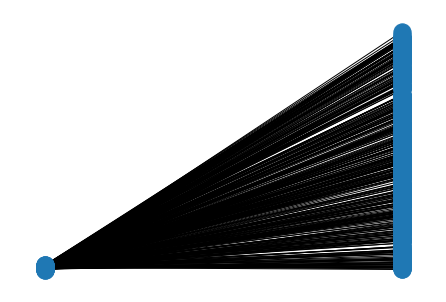

In [120]:
# Create a graph for first article edges
import networkx as nx
import matplotlib.pyplot as plt

# Plot as a bipartite graph with sentances and words
G = nx.Graph()
G.add_weighted_edges_from(all_articles_edges[0])
# G.add_weighted_edges_from(all_articles_edges[0][:30])
# One side for up to max_article_len nodes and the other side for the rest
pos = {}
for i in range(len(padded_articles[0])):
    pos[i] = (0, i)

for i in range(len(padded_articles[0]), len(padded_articles[0])+len(all_unique_words)):
    pos[i] = (1, i-len(padded_articles[0]))

nx.draw(G, pos, with_labels=False, font_weight='bold')
plt.show()

# Auto endcoder model

- Node Features = [Sentance Embeddings, Word Embeddings]
- Edges = [edges between sentace and word node]

In [147]:
from tensorflow.keras import layers, models

# Create a Keras Graph model
class GraphAutoencoder(tf.keras.Model):
    def __init__(self, input_size, hidden_size):
        super(GraphAutoencoder, self).__init__()

        # Encoder
        self.encoder = layers.Dense(hidden_size, activation='relu')

        # Decoder
        self.decoder = layers.Dense(input_size, activation='sigmoid')

    def call(self, inputs_node_features, inputs_adj_matrix=None, training=None, mask=None):
        x = self.encoder(inputs_node_features)
        x = self.decoder(x)
        return x


In [148]:

# Instantiate the model
input_size = 768 # Size of node features
hidden_size = 256
model = GraphAutoencoder(input_size, hidden_size)

# Define the loss function and optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


In [149]:
len(padded_articles_sentence_embeddings[1][0])

768

In [150]:
# Create node features from the sentence embeddings for each article
all_articles_node_features = []
for article in padded_articles_sentence_embeddings:
    article_node_features = []
    for sentence in article:
        article_node_features.append(sentence)
    all_articles_node_features.append(article_node_features)

# Convert to tensor node_features_tensor,adjacency_matrix_tensor
node_features_tensor = tf.constant(all_articles_node_features)
adjacency_matrix_tensor = tf.constant(all_articles_adjacency_matrices)

In [151]:

# Training loop
num_epochs = 1

for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        reconstructed_features = model(node_features_tensor,adjacency_matrix_tensor)
        loss = loss_fn(node_features_tensor, reconstructed_features)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.numpy():.4f}')

Input shape:  (5, 31, 768)
Training shape:  (10, 31, 1521)
Epoch 1/1, Loss: 0.3708


In [142]:
# After training, you can use the learned embeddings for downstream tasks
node_features = np.array(all_articles_node_features[0], dtype=np.float32)
node_features_tensor = tf.constant(node_features)
learned_embeddings = model(node_features_tensor).numpy()
# print(learned_embeddings)

[[0.0000000e+00 9.2922093e-21 9.6255267e-32 ... 1.2514994e-30
  2.6186494e-36 0.0000000e+00]
 [0.0000000e+00 1.5590403e-27 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 8.7493497e-23 1.0816269e-34 ... 2.2251794e-33
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 8.8576142e-24 8.7041136e-37 ... 5.1774035e-35
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.6249732e-25 3.6056323e-38 ... 4.2395547e-37
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.9557367e-26 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


In [146]:
len(learned_embeddings), len(learned_embeddings[0])

(31, 768)

In [145]:
# Get total count greater than 0.1
count = 0
for i in range(len(learned_embeddings)):
    for j in range(len(learned_embeddings[i])):
        if learned_embeddings[i][j] > 0.4:
            count += 1
print("Number of values greater than 0.4: ", count, " out of ", len(learned_embeddings)*len(learned_embeddings[0]))

Number of values greater than 0.4:  1336  out of  23808


In [93]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dropout, Dense, Layer, LeakyReLU
# from tensorflow.keras.models import Model

# class GraphAttention(Layer):
#     def __init__(self, units, attn_heads=1, dropout_rate=0.5, activation='relu', **kwargs):
#         super(GraphAttention, self).__init__(**kwargs)
#         self.units = units
#         self.attn_heads = attn_heads
#         self.dropout_rate = dropout_rate
#         self.activation = tf.keras.activations.get(activation)

#     def build(self, input_shape):
#         self.W = self.add_weight(
#             shape=(input_shape[0][-1], self.units * self.attn_heads),
#             initializer='glorot_uniform',
#             trainable=True,
#             name='kernel'
#         )
#         self.b = self.add_weight(
#             shape=(self.units * self.attn_heads,),
#             initializer='zeros',
#             trainable=True,
#             name='bias'
#         )
#         super(GraphAttention, self).build(input_shape)

#     def call(self, inputs):
#         X, A = inputs
#         h = tf.matmul(X, self.W) + self.b
#         h = tf.reshape(h, (-1, self.attn_heads, self.units))
#         attn_coeffs = tf.nn.softmax(tf.matmul(tf.matmul(h, tf.transpose(h, [0, 2, 1])), A))
#         out = tf.matmul(attn_coeffs, h)
#         out = tf.reshape(out, (-1, self.units * self.attn_heads))
#         out = self.activation(out)
#         return out

# def graph_autoencoder_gat(node_features_shape, num_nodes, latent_dim):
#     # Encoder
#     encoder_inputs = Input(shape=node_features_shape)
#     A = Input(shape=(num_nodes, num_nodes))  # Adjacency matrix placeholder

#     encoder = GraphAttention(units=64)([encoder_inputs, A])
#     encoder = Dropout(0.2)(encoder)
#     encoder = GraphAttention(units=latent_dim)([encoder, A])

#     # Decoder
#     decoder = GraphAttention(units=64)([encoder, A])
#     decoder = Dropout(0.2)(decoder)
#     decoder_outputs = GraphAttention(units=node_features_shape[0], activation='sigmoid')([decoder, A])

#     # Autoencoder model
#     autoencoder = Model([encoder_inputs, A], decoder_outputs)

#     # Compile the model
#     autoencoder.compile(optimizer='adam', loss='mean_squared_error')

#     return autoencoder


In [100]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras import layers, models

# # Define a simple graph (you can replace this with your own graph data)
# adjacency_matrix = np.array([[[0, 1, 0, 1], [1, 0, 1, 0], [0, 1, 0, 0]],[[0, 1, 0, 1], [1, 0, 1, 0], [0, 1, 0, 0]]], dtype=np.float32)
# node_features = np.array([[[1.0,2.0], [2.0,3.0], [3.0,4.0]],[[1.0,2.0], [2.0,3.0], [3.0,4.0]]], dtype=np.float32)

# # Create a Keras Graph model
# class GraphAutoencoder(tf.keras.Model):
#     def __init__(self, input_size, hidden_size):
#         super(GraphAutoencoder, self).__init__()

#         # Encoder
#         self.encoder = layers.Dense(hidden_size, activation='relu')

#         # Decoder
#         self.decoder = layers.Dense(input_size, activation='sigmoid')

#     def call(self, inputs, training=None, mask=None):
#         x = self.encoder(inputs)
#         x = self.decoder(x)
#         return x
# # Instantiate the model
# input_size = 2 # Size of node features
# hidden_size = 64
# model = GraphAutoencoder(input_size, hidden_size)

# # Define the loss function and optimizer
# loss_fn = tf.keras.losses.MeanSquaredError()
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# # Convert numpy arrays to TensorFlow tensors
# adjacency_matrix_tensor = tf.constant(adjacency_matrix)
# node_features_tensor = tf.constant(node_features)

# # Training loop
# num_epochs = 100

# for epoch in range(num_epochs):
#     with tf.GradientTape() as tape:
#         reconstructed_features = model(node_features_tensor,adjacency_matrix_tensor)
#         loss = loss_fn(node_features_tensor, reconstructed_features)

#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#     if epoch % 10 == 0:
#         print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.numpy():.4f}')

# # After training, you can use the learned embeddings for downstream tasks
# node_features = np.array([[2.0,2.0], [3.0,3.0], [4.0,4.0]], dtype=np.float32)
# node_features_tensor = tf.constant(node_features)
# learned_embeddings = model(node_features_tensor).numpy()
# print(learned_embeddings)

Epoch 1/100, Loss: 4.5801
Epoch 11/100, Loss: 3.2369
Epoch 21/100, Loss: 3.1734
Epoch 31/100, Loss: 3.1687
Epoch 41/100, Loss: 3.1678
Epoch 51/100, Loss: 3.1676
Epoch 61/100, Loss: 3.1674
Epoch 71/100, Loss: 3.1674
Epoch 81/100, Loss: 3.1673
Epoch 91/100, Loss: 3.1673
[[0.99877673 0.999742  ]
 [0.9999231  0.9999918 ]
 [0.9999951  0.99999976]]


In [118]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dropout, Reshape
# from tensorflow.keras.models import Model
# from sklearn.model_selection import train_test_split

# class GraphAttention(tf.keras.layers.Layer):
#     def __init__(self, units, attn_heads=1, dropout_rate=0.5, activation='relu', **kwargs):
#         super(GraphAttention, self).__init__(**kwargs)
#         self.units = units
#         self.attn_heads = attn_heads
#         self.dropout_rate = dropout_rate
#         self.activation = tf.keras.activations.get(activation)

#     def build(self, input_shape):
#         self.W = self.add_weight(
#             shape=(input_shape[0][-1], self.units * self.attn_heads),
#             initializer='glorot_uniform',
#             trainable=True,
#             name='kernel'
#         )
#         self.b = self.add_weight(
#             shape=(self.units * self.attn_heads,),
#             initializer='zeros',
#             trainable=True,
#             name='bias'
#         )
#         super(GraphAttention, self).build(input_shape)

#     def call(self, inputs):
#         X, A = inputs
#         h = tf.matmul(X, self.W) + self.b
#         h = tf.reshape(h, (-1, self.attn_heads, self.units))
#         attn_coeffs = tf.nn.softmax(tf.matmul(tf.matmul(h, tf.transpose(h, [0, 2, 1])), A))
#         out = tf.matmul(attn_coeffs, h)
#         out = tf.reshape(out, (-1, self.units * self.attn_heads))
#         out = self.activation(out)
#         return out

# def graph_autoencoder_gat(node_features_shape, num_nodes, latent_dim):
#     # Encoder
#     encoder_inputs = Input(shape=node_features_shape)
#     A = Input(shape=(num_nodes, num_nodes))  # Adjacency matrix placeholder

#     encoder = GraphAttention(units=64)([encoder_inputs, A])
#     encoder = Dropout(0.2)(encoder)
#     encoder = Reshape((num_nodes * latent_dim,))(encoder)  # Reshape to match decoder input size

#     # Decoder
#     decoder = Dense(64, activation='relu')(encoder)  # Example dense layer, modify as needed
#     decoder = Dropout(0.2)(decoder)
#     decoder_outputs = Dense(node_features_shape[0], activation='sigmoid')(decoder)

#     # Autoencoder model
#     autoencoder = Model([encoder_inputs, A], decoder_outputs)

#     # Compile the model
#     autoencoder.compile(optimizer='adam', loss='mean_squared_error')

#     return autoencoder

# # Generate random sample inputs for training and testing
# num_nodes = 50
# node_features_shape = (10,)  # Assuming each node has 10 features

# # Generate random adjacency matrices (assuming undirected graphs)
# adj_matrices_train = [np.random.randint(0, 2, size=(num_nodes, num_nodes)) for _ in range(100)]  # 100 training graphs
# adj_matrices_test = [np.random.randint(0, 2, size=(num_nodes, num_nodes)) for _ in range(20)]    # 20 testing graphs

# # Generate random node features for each graph
# node_features_train = [np.random.rand(num_nodes, node_features_shape[0]) for _ in range(100)]  # Random features for training
# node_features_test = [np.random.rand(num_nodes, node_features_shape[0]) for _ in range(20)]    # Random features for testing

# # Create the graph autoencoder model
# latent_dim = 32  # Adjust as needed
# model = graph_autoencoder_gat(node_features_shape, num_nodes, latent_dim)

# # Train the model
# model.fit([node_features_train, adj_matrices_train], node_features_train, epochs=10, batch_size=32, validation_split=0.2)

# # Get testing outputs for node classification
# # For example, getting the output of the encoder part for node classification
# encoded_features = model.layers[2].predict([node_features_test, adj_matrices_test])

# # You can use the 'encoded_features' for node classification or further downstream tasks
# # Adjust the final layers or outputs for node classification based on your specific task requirements


ValueError: Exception encountered when calling layer "graph_attention_5" (type GraphAttention).

in user code:

    File "C:\Users\PULKIT\AppData\Local\Temp\ipykernel_16548\550451204.py", line 34, in call  *
        attn_coeffs = tf.nn.softmax(tf.matmul(tf.matmul(h, tf.transpose(h, [0, 2, 1])), A))

    ValueError: Dimensions must be equal, but are 1 and 50 for '{{node graph_attention_5/MatMul_2}} = BatchMatMulV2[T=DT_FLOAT, adj_x=false, adj_y=false](graph_attention_5/MatMul_1, Placeholder_1)' with input shapes: [?,1,1], [?,50,50].


Call arguments received by layer "graph_attention_5" (type GraphAttention):
  • inputs=['tf.Tensor(shape=(None, 10), dtype=float32)', 'tf.Tensor(shape=(None, 50, 50), dtype=float32)']